In [60]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import numpy as np
import matplotlib.pyplot as plt
import pathlib
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay

In [4]:

x = np.load('../dados/Hypercellularity/13.2-dataset_image_200x200/x.npy')
y = np.load('../dados/Hypercellularity/13.2-dataset_image_200x200/y.npy')

In [3]:
x.shape

(811, 200, 200, 3)

In [28]:
def draw_learning_curves(history):

    plt.figure(figsize=(8, 6), dpi=80)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'val'], loc='upper left')

    plt.show()
    plt.figure(figsize=(8, 6), dpi=80)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'val'], loc='upper left')

    plt.show()


def draw_roc_curves(metrics):

    plt.figure(figsize=(8, 6), dpi=80)
    plt.plot(metrics['fpr'], metrics['tpr'], color='darkorange', lw=2,label='ROC curve (area = %0.2f)' % metrics['auc'])
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.ylim([0.0, 1.05])
    plt.title('ROC Curve')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc="lower right")

    plt.show()
    plt.figure(figsize=(8, 6), dpi=80)
    plt.plot(metrics['recall_C'], metrics['precision_C'], color='darkorange', lw=2,label='ROC curve (area = %0.2f)' % metrics['auc_precision_recall'])
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.ylim([0.0, 1.05])
    plt.title('Precision Recall Curve')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc="lower right")

    plt.show()


def draw_confusion_matrix(labels, y_pred, display_labels=None):
    # Generate confusion matrix plot
    
    cf_matrix= confusion_matrix(labels, y_pred)
    # cf_matrix= confusion_matrix(rounded_labels, y_pred, normalize='pred')
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, 
                                display_labels=display_labels)
    disp.plot()
    disp.ax_.set_xticklabels(display_labels, rotation=12)
    # plt.title('Confusion Matrix of Subject: ' + sub )

    plt.show()

In [5]:
def identity_block(x, filter):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

def convolutional_block(x, filter):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same', strides = (2,2))(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Processing Residue with conv(1,1)
    x_skip = tf.keras.layers.Conv2D(filter, (1,1), strides = (2,2))(x_skip)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

def ResNet34(shape = (32, 32, 3), classes = 10):
    # Step 1 (Setup Input Layer)
    x_input = tf.keras.layers.Input(shape)
    x = tf.keras.layers.ZeroPadding2D((3, 3))(x_input)
    # Step 2 (Initial Conv layer along with maxPool)
    x = tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)
    # Define size of sub-blocks and initial filter size
    block_layers = [3, 4, 6, 3]
    filter_size = 64
    # Step 3 Add the Resnet Blocks
    for i in range(4):
        if i == 0:
            # For sub-block 1 Residual/Convolutional block not needed
            for j in range(block_layers[i]):
                x = identity_block(x, filter_size)
        else:
            # One Residual/Convolutional Block followed by Identity blocks
            # The filter size will go on increasing by a factor of 2
            filter_size = filter_size*2
            x = convolutional_block(x, filter_size)
            for j in range(block_layers[i] - 1):
                x = identity_block(x, filter_size)
    # Step 4 End Dense Network
    x = tf.keras.layers.AveragePooling2D((2,2), padding = 'same')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, activation = 'relu')(x)
    x = tf.keras.layers.Dense(classes, activation = 'softmax')(x)
    model = tf.keras.models.Model(inputs = x_input, outputs = x, name = "ResNet34")
    return model

In [82]:
y_ = tf.keras.utils.to_categorical(y)
x_train, x_test, y_train, y_test = train_test_split(x,  y, test_size=0.20, random_state=42)
x_train, x_validation, y_train, y_validation = train_test_split(x_train,  y_train, test_size=0.20, random_state=42)

In [7]:
model = ResNet34(shape = (200, 200, 3), classes = 2)

In [8]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [11]:
hist = model.fit(x_train, y_train, epochs=100, batch_size=20,  validation_data=(x_validation, y_validation))

Epoch 1/100
26/26 [==============================] - 2s 82ms/step - loss: 0.1837 - accuracy: 0.9402 - val_loss: 0.7106 - val_accuracy: 0.7077
Epoch 2/100
26/26 [==============================] - 2s 80ms/step - loss: 0.1179 - accuracy: 0.9556 - val_loss: 0.4995 - val_accuracy: 0.8000
Epoch 3/100
26/26 [==============================] - 2s 79ms/step - loss: 0.1312 - accuracy: 0.9575 - val_loss: 2.8451 - val_accuracy: 0.6154
Epoch 4/100
26/26 [==============================] - 2s 79ms/step - loss: 0.0973 - accuracy: 0.9672 - val_loss: 0.7204 - val_accuracy: 0.7769
Epoch 5/100
26/26 [==============================] - 2s 79ms/step - loss: 0.0573 - accuracy: 0.9826 - val_loss: 0.4314 - val_accuracy: 0.8692
Epoch 6/100
26/26 [==============================] - 2s 78ms/step - loss: 0.1762 - accuracy: 0.9440 - val_loss: 11.4653 - val_accuracy: 0.6000
Epoch 7/100
26/26 [==============================] - 2s 79ms/step - loss: 0.1564 - accuracy: 0.9440 - val_loss: 3.0794 - val_accuracy: 0.6308
Epoch

In [12]:
_, accuracy = model.evaluate(x_test, y_test)
probs = model.predict(x_test)

y_pred = probs.argmax(axis=-1)
y_test = y_test.argmax(axis=-1)

6/6 [==============================] - 1s 33ms/step


In [39]:
metric = {}
metric['precision'], metric['recall'], metric['fscore'], metric['support'] = metrics.precision_recall_fscore_support(y_test, y_pred, average='weighted')
metric['kappa'] = metrics.cohen_kappa_score(y_test, y_pred)
metric['fpr'], metric['tpr'], thresholds = metrics.roc_curve(y_test, probs[:,1], pos_label=1)
metric['auc'] = metrics.auc(metric['fpr'], metric['tpr'])
metric['precision_C'], metric['recall_C'], thresholds = metrics.precision_recall_curve(y_test, probs[:,1], pos_label=1)
# Use AUC function to calculate the area under the curve of precision recall curve
metric['auc_precision_recall'] = metrics.auc(metric['recall_C'], metric['precision_C'])


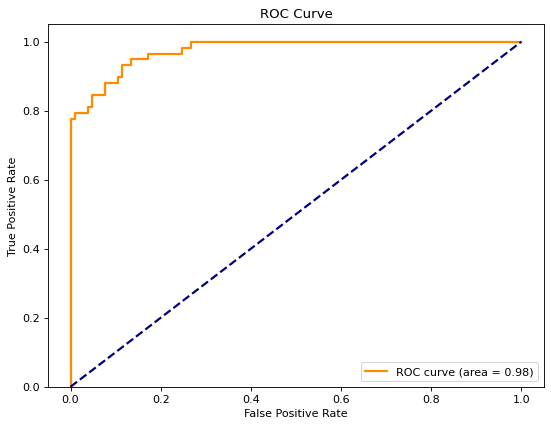

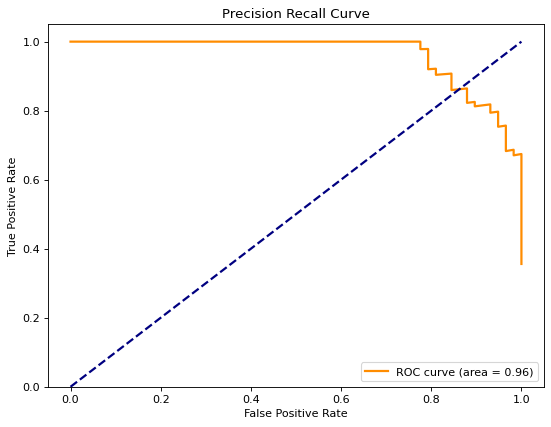

In [40]:
draw_roc_curves(metric)

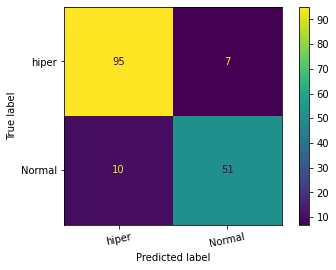

In [31]:
draw_confusion_matrix(y_pred, y_test, ['hiper', 'Normal'])

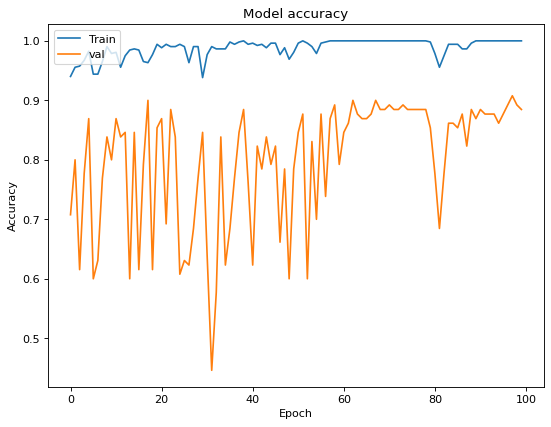

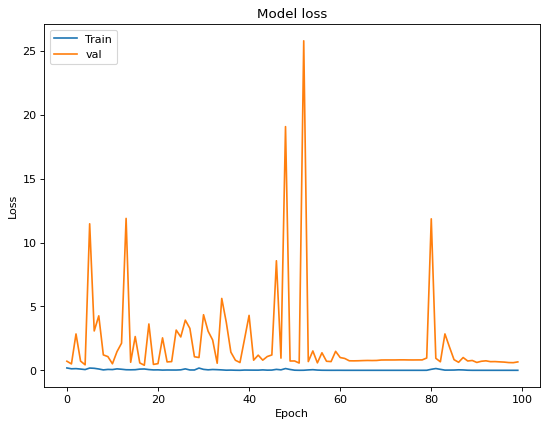

In [26]:
draw_learning_curves(hist)

In [75]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 200  # We'll resize input images to this size
patch_size = 16  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [ ]:
# ata_augmentation = keras.Sequential(
#     [
#         layers.Normalization(),
#         layers.Resizing(image_size, image_size),
#         layers.RandomFlip("horizontal"),
#         layers.RandomRotation(factor=0.02),
#         layers.RandomZoom(
#             height_factor=0.2, width_factor=0.2
#         ),
#     ],
#     name="data_augmentation",
# )
# # Compute the mean and the variance of the training data for normalization.
# data_augmentation.layers[0].adapt(x_train)

In [76]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

def create_vit_classifier(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    # augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(inputs)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [86]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_data=(x_validation, y_validation),
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier(input_shape=(200, 200, 3), num_classes=2)
history = run_experiment(vit_classifier)

Epoch 1/100


ResourceExhaustedError: Graph execution error:

Detected at node 'model_3/multi_head_attention_30/einsum/Einsum' defined at (most recent call last):
    File "c:\Users\Maods\.conda\envs\tf_2.6\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\Maods\.conda\envs\tf_2.6\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\Maods\.conda\envs\tf_2.6\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\Maods\.conda\envs\tf_2.6\lib\site-packages\traitlets\config\application.py", line 972, in launch_instance
      app.start()
    File "c:\Users\Maods\.conda\envs\tf_2.6\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "c:\Users\Maods\.conda\envs\tf_2.6\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\Maods\.conda\envs\tf_2.6\lib\asyncio\base_events.py", line 596, in run_forever
      self._run_once()
    File "c:\Users\Maods\.conda\envs\tf_2.6\lib\asyncio\base_events.py", line 1890, in _run_once
      handle._run()
    File "c:\Users\Maods\.conda\envs\tf_2.6\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\Maods\.conda\envs\tf_2.6\lib\site-packages\ipykernel\kernelbase.py", line 504, in dispatch_queue
      await self.process_one()
    File "c:\Users\Maods\.conda\envs\tf_2.6\lib\site-packages\ipykernel\kernelbase.py", line 493, in process_one
      await dispatch(*args)
    File "c:\Users\Maods\.conda\envs\tf_2.6\lib\site-packages\ipykernel\kernelbase.py", line 400, in dispatch_shell
      await result
    File "c:\Users\Maods\.conda\envs\tf_2.6\lib\site-packages\ipykernel\kernelbase.py", line 724, in execute_request
      reply_content = await reply_content
    File "c:\Users\Maods\.conda\envs\tf_2.6\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "c:\Users\Maods\.conda\envs\tf_2.6\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\Maods\.conda\envs\tf_2.6\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "c:\Users\Maods\.conda\envs\tf_2.6\lib\site-packages\IPython\core\interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "c:\Users\Maods\.conda\envs\tf_2.6\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\Maods\.conda\envs\tf_2.6\lib\site-packages\IPython\core\interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\Maods\.conda\envs\tf_2.6\lib\site-packages\IPython\core\interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\Maods\.conda\envs\tf_2.6\lib\site-packages\IPython\core\interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Maods\AppData\Local\Temp\ipykernel_40968\3359545077.py", line 41, in <cell line: 41>
      history = run_experiment(vit_classifier)
    File "C:\Users\Maods\AppData\Local\Temp\ipykernel_40968\3359545077.py", line 23, in run_experiment
      history = model.fit(
    File "c:\Users\Maods\.conda\envs\tf_2.6\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Maods\.conda\envs\tf_2.6\lib\site-packages\keras\engine\training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\Maods\.conda\envs\tf_2.6\lib\site-packages\keras\engine\training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "c:\Users\Maods\.conda\envs\tf_2.6\lib\site-packages\keras\engine\training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Maods\.conda\envs\tf_2.6\lib\site-packages\keras\engine\training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "c:\Users\Maods\.conda\envs\tf_2.6\lib\site-packages\keras\engine\training.py", line 889, in train_step
      y_pred = self(x, training=True)
    File "c:\Users\Maods\.conda\envs\tf_2.6\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Maods\.conda\envs\tf_2.6\lib\site-packages\keras\engine\training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\Maods\.conda\envs\tf_2.6\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Maods\.conda\envs\tf_2.6\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\Maods\.conda\envs\tf_2.6\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Maods\.conda\envs\tf_2.6\lib\site-packages\keras\engine\functional.py", line 458, in call
      return self._run_internal_graph(
    File "c:\Users\Maods\.conda\envs\tf_2.6\lib\site-packages\keras\engine\functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\Maods\.conda\envs\tf_2.6\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Maods\.conda\envs\tf_2.6\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\Maods\.conda\envs\tf_2.6\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Maods\.conda\envs\tf_2.6\lib\site-packages\keras\layers\attention\multi_head_attention.py", line 509, in call
      attention_output, attention_scores = self._compute_attention(
    File "c:\Users\Maods\.conda\envs\tf_2.6\lib\site-packages\keras\layers\attention\multi_head_attention.py", line 472, in _compute_attention
      attention_scores = tf.einsum(self._dot_product_equation, key, query)
Node: 'model_3/multi_head_attention_30/einsum/Einsum'
OOM when allocating tensor with shape[256,4,144,144] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model_3/multi_head_attention_30/einsum/Einsum}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_76236]

In [85]:

import gc
gc.collect()

77084

In [69]:
y_test

array([1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)